# Final Project- Jake Dale

Problem: Real estate (houses in particular) is one of the most important asset classes and stores of wealth, yet pricing and valuations are not nearly as transparent as for other assets. Reasons include the fact that houses are not fungible, and market prices are available only when a house is put up for sale. However, many features of a house are observable and measurable at any time.

Proposal: There is a database of houses in Ames, IA (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The data is broken into both a training set and a test set, and in addition to the target variable (house price) to be predicted, there are 79 other features that could have explanatory power over the price. The plan is to analyze the dataset to see if a model can be derived that provides an accurate prediction for the house price as a function of the features, within a certain margin of error.

In our data, the SalePrice is the target variable. My intuition, based off of the "Location, Location, Location" saying, is that categorical features such as the neighborhood and proximity to key roads, will be more important.

In [1]:
# Download the necessary libraries and import the data set.

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

path = './housing.csv'
housing = pd.read_csv(path)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

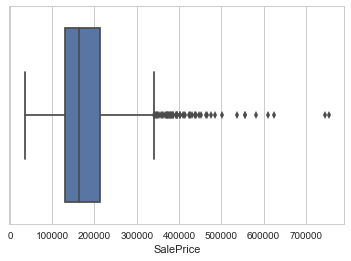

In [64]:
sns.set_style('whitegrid')
ax= sns.boxplot(x=housing['SalePrice']);

In [65]:
housing.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

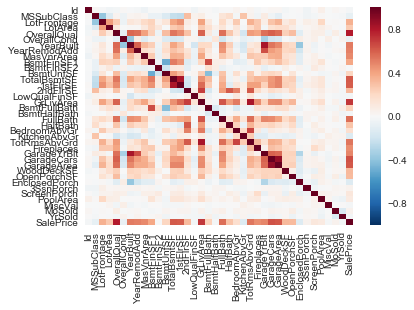

In [5]:
corr = housing.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

## Data Cleaning

The Kaggle link has a data description attached to go over the meaning of each feature in the dataset. There were several different types of features, each of which has to be cleaned and processed differenently.

There is one feature, MSSubClass that has numerical values, but is in fact a non-ordered categorical feature,
and will need to be dummy encoded.

In [8]:
housing = pd.get_dummies(housing, columns=['MSSubClass'], drop_first=True)

There are some text-encoded categorical features that are ordered, and can therefore be numerically encoded. Ten of them use the same Excellent to Poor rating scheme, so we can loop through them and map. However, others use different ratings schemes or take different values, and have to be handled separately.

In [10]:
#Ten of these features have the same scheme.
ordinal_columns=[]
quality_mappings = {'Ex': 5, 'Gd': 4 , 'TA': 3 , 'Fa' : 2 ,  'Po' : 1 , 'NA' : 0}

for column in housing:
    if 'TA' in housing[column].value_counts() or 'Ex' in housing[column].value_counts():
            ordinal_columns.append(column)

for column in ordinal_columns:
    housing[column]=housing[column].map(quality_mappings)

#Two features, regarding the basement finish type, have a slightly different ratings scheme.

basement_columns=['BsmtFinType1', 'BsmtFinType2']
basement_mappings= {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2, 'Unf':1, 'NA':0}

for column in basement_columns:
    housing[column]=housing[column].map(basement_mappings)
    
#There are then several features with unique ratings scales, mapped separately from the others.
#They are BsmtExposure, Functional, LandSlope, GarageFinish, PavedDrive, LotShape.

exposure_mappings= {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
housing['BsmtExposure']=housing['BsmtExposure'].map(exposure_mappings)

functional_mappings= {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1, 'NA': 0}
housing['Functional']=housing['Functional'].map(functional_mappings)

landslope_mappings= {'NA':0, 'Gtl':1, 'Mod':2, 'Sev':3}
housing['LandSlope']=housing['LandSlope'].map(landslope_mappings)

garage_mappings= {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
housing['GarageFinish']=housing['GarageFinish'].map(garage_mappings)

paved_mappings={'Y':2, 'P':1, 'N':0}
housing['PavedDrive']=housing['PavedDrive'].map(garage_mappings)

lot_mappings= {'IR3':3, 'IR2':2, 'IR1':1, 'Reg':0}
housing['LotShape']=housing['LotShape'].map(lot_mappings)

The remaining features with datatype=object cannot sensibly be ordered, so we will use dummy encoding on the rest to convert them into numerical (integer) features. As a final step, we can go through and fill the remaining NA values with 0. Because there are null values for many categorical features, we didn't drop the first dummy variable. Because some features don't apply to some houses, we need all of the dummy variables.

In [12]:
#Convert the remaining object-typed features into integer-typed dummies.

dummy_features=[]

for column in housing:
    if housing[column].dtype==object:
        dummy_features.append(column)

for column in dummy_features:
    housing=pd.get_dummies(housing, columns=[column], drop_first=False)

In [13]:
#The final step in our data cleaning involves replacing the null values with zero, which should make sense in the context of our modified features.
housing.fillna(value=0, inplace=True)

In [14]:

housing.describe()

,Id,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,57.623288,10516.828082,0.408219,1.062329,6.099315,5.575342,1971.267808,1984.865753,103.117123,...,0.003425,0.083562,0.002055,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,421.610009,34.664304,9981.264932,0.582296,0.276232,1.382997,1.112799,30.202904,20.645407,180.731373,...,0.058440,0.276824,0.045299,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,1.000000,0.000000,1300.000000,0.000000,1.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,42.000000,7553.500000,0.000000,1.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,730.500000,63.000000,9478.500000,0.000000,1.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1095.250000,79.000000,11601.500000,1.000000,1.000000,7.000000,6.000000,2000.000000,2004.000000,164.250000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1460.000000,313.000000,215245.000000,3.000000,3.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model Creation

First, we will create a null benchmark against which to test our models by always predicting the simple mean. We will compare the root mean squared error (RMSE) against the results of our later models.

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics


#Set up X and y as our features and response variable, respectively.
feature_cols = housing.columns.drop('SalePrice')
y= housing.SalePrice
X= housing[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create an array with the same shape as y_test, then fill it with the mean value of the sample in y_test.
y_null = np.zeros_like(y_test, dtype=float)

y_null.fill(y_test.mean())

print (y_test.mean())
np.sqrt(metrics.mean_squared_error(y_test, y_null))


183078.819178


77656.195531012636

For our primary model, we will use Random Forest, which should offer the greatest improvement over the simple mean. Random Forest should provide the greatest predictive power, and help sort through and prioritize the features. After dummy variable creation, we have 241 features for 1460 total instances. In addition to creating a model, and viewing its predicted out of sample score and RMSE, we are also interested in which features are most important.

In [16]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

In [17]:
# Compute feature importances.

pd.DataFrame({'Feature':feature_cols, 'Importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
5,OverallQual,0.057863
25,GrLivArea,0.045550
20,TotalBsmtSF,0.037886
40,GarageArea,0.036898
37,GarageYrBlt,0.030827
39,GarageCars,0.030787
16,BsmtFinSF1,0.029528
12,BsmtQual,0.028606
22,1stFlrSF,0.028328
23,2ndFlrSF,0.025593


In [18]:
#Compute the OOB score and RMSE.
print((rfreg.oob_score_))


scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))



0.835710226929


31879.720433631563

The RMSE is ~31k, less than half the ~78k when relying on the mean price alone.
The most important features include overall construction quality, square feet above ground, square feet in the basement, and square feet in the garage.
Notably, the many subjective quality score features that we processed appear amongst the most important features, as do more basic ones like square footage.

We will try to tune the max features to see if we can improve the RMSE. The 10-fold cross-validation is too slow to try all 241 possibilities, but we will see if increasing to 24 provides a better RMSE.

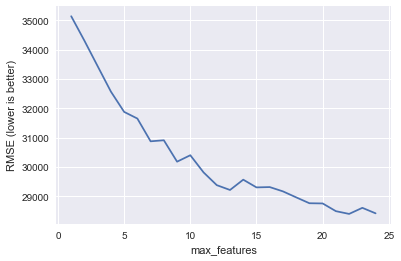

In [19]:
feature_range = list(range(1, 25))


RMSE_scores = []
                     
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [20]:
sorted(zip(RMSE_scores, feature_range))[0]

(28399.65683466844, 22)

The RMSE does get substantially lower as the max features is increased, but the rate starts to tail off. 24 provides the lowest RMSE tested, at ~28k.

This give us an idea of the lower bound for the RMSE that can be achieved. However, a builder or homeowner may want a more interpretable model to get a sense
of what contributes most to a home's value, and what if any improvements can be made to increase it. A simple linear regression would do that, at the expense 
of at least some accuracy. We will try to see what the tradeoff is.

In [42]:

from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

linreg= LinearRegression()
linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

30117.7320346


In [43]:
coefficient_output = pd.Series(dict(zip(feature_cols, linreg.coef_))).sort_values()
print (linreg.intercept_)
print (coefficient_output.head(10))
print (coefficient_output.tail(10))

-1225960.64085
RoofMatl_ClyTile    -596458.719545
Condition2_PosN     -198145.225736
MiscFeature_TenC     -75761.407736
Exterior2nd_Other    -34333.722350
MSSubClass_180       -33806.499449
MSSubClass_75        -32194.625736
Heating_OthW         -31346.135592
Foundation_Wood      -25616.000082
MSSubClass_120       -25579.058220
Utilities_NoSeWa     -25028.707878
dtype: float64
GarageType_Basment       34739.453995
Neighborhood_NridgHt     39002.218050
Exterior1st_BrkComm      55892.712064
RoofMatl_WdShake         66565.352892
RoofMatl_Tar&Grv         70750.701747
RoofMatl_Roll            79212.469299
RoofMatl_CompShg         93451.173522
Condition2_PosA         101697.066988
RoofMatl_Membran        127993.967678
RoofMatl_WdShngl        158485.054408
dtype: float64


Looking through the ten most positive and ten most negative coefficients, there are some extreme outliers. There is likely collinearity or overfitting, despite the fact that there weren't many features that were obviously highly correlated. The RMSE is above the near optimal ~28k value that we found when using the Random Forest.

In [44]:
scores=cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')
print (np.mean(np.sqrt(-scores)))

print (housing.MiscFeature_TenC.sum())
print (housing.RoofMatl_ClyTile.sum())
print (housing.RoofMatl_Membran.sum())
print (housing.RoofMatl_WdShngl.sum())

33580.8757763
1
1
1
6


Some of the more extreme outliers appear to be the result of too few data points. We will try building another linear model, using only the feature columns that were found to be most important earlier when we were using the Random Forest.

In [46]:
Important_cols=['OverallQual', 'GrLivArea','TotalBsmtSF',	'GarageArea',	'GarageYrBlt',	'GarageCars',	'BsmtFinSF1','BsmtQual'	,'1stFlrSF','2ndFlrSF']
X2= housing[Important_cols]

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=123)

linreg= LinearRegression()
linreg.fit(X2_train,y_train)

y_pred = linreg.predict(X2_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

35546.8267837


In [47]:
coefficient_output2 = pd.Series(dict(zip(Important_cols, linreg.coef_))).sort_values()
print (linreg.intercept_)
print (coefficient_output2)

-94742.2859095
GrLivArea        -32.522775
GarageYrBlt      -14.786447
TotalBsmtSF       -7.777781
GarageArea         4.344599
BsmtFinSF1        19.761692
2ndFlrSF          73.263248
1stFlrSF         100.924641
BsmtQual       11682.282470
OverallQual    20931.886587
GarageCars     21785.110861
dtype: float64


##  Some closing observations
Looking at the coefficients for the final linear regression, the y-intercept still shows that the housing price is still not entirely linear with respect to the most important variables, at least if we move far outside the observed ranges of each of the features. Furthermore, there is a fairly steep price (~6k) in increased RMSE that has to be paid for the easy, dollar-value interpretability of an non-regularized linear regression. However, we can still gain some insights for homeowners or builders to use, even if they are ones that aren't easily actionable. The features that were deemed most important, which were primarily based on physical size and quality scores, were not the ones originally predicted.

For further analysis, here are some areas I would examine:
- Data for different towns. Ames, IA may not be representative of other cities.
- Clustering or KNN. This may have helped with some of the more extreme outliers.
- Eliminating the subjective features (ie quality scores) to see if these can be derived empirically.
